![](https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png)

# Chasing cyclicities

In this notebook, we demonstrate the use of the spectral and wavelet analysis features of [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/master/index.html) using a sea surface temperature reconstruction from Site ODP846 in the Eastern Equatorial Pacific. The goal is to explore the periodicities present in this 5 million years record and explore any coherency between insolation and the sea surface temperature record. 

## Table of Contents
* [Data](#data)
* [Data Exploration](#dataexp)
* [Spectral and wavelet analysis](#analysis)
    * [Benthic record](#benthic)
        * [Data Exploration](#benthicexp)
        * [Analysis](#benthicana)
        * [Comparison with benthic LR04 stack](#LR04)
    * [Planktonic record](#planktonic)
        * [Data Exploration](#planktonicexp)
        * [Analysis](#planktonicana)
            * [Effect of age uncertainty](#age)
* [Relationship to insolation](#sol)
* [Conclusion](#conclusion)
* [References](#ref)



## <a name='data'>Data</a>

The record is described in:

* Mix, A. C., J. Le, and N. J. Shackleton (1995), Benthic foraminiferal stable isotope stratigraphy from Site 846: 0–1.8 Ma, Proc. Ocean Drill. Program Sci. Results, 138, 839–847.
* Shackleton, N. J., Hall, M. A., & Pate, D. (1995). Pliocene stable isotope stratigraphy of ODP Site 846. Proc. Ocean Drill. Program Sci. Results, 138, 337-356. 
* Lawrence, K. T., Liu, Z. H., & Herbert, T. D. (2006). Evolution of the eastern tropical Pacific through Plio-Pleistocne glaciation. Science, 312(5770), 79-83.

The data were aligned to the Benthic Stack of [Lisiecki & Raymo (2005)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071) (LR04) using the HMM-Match algorithm developed by [Lin et al. (2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014PA002713) as used by [Khider et al, 2017](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2016PA003057). The latter is a probabilistic method that generates an ensemble of 1000 possible age models compatible with the chronostratigraphic constraints.

The dataset is stored in the Linked Paleo Data Format (LiPD, [McKay and Emile-Geay (2016)](https://lipd.net)) and available from the same GitHub repository as the notebook.

## <a name='dataexp'>Data Exploration</a>

Let's import this file into Pyleoclim and make a informational dashboard about the dataset. The cell below will import the various packages needed throughout the notebook, including Pyleoclim.

In [1]:
import pyleoclim as pyleo
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# For insolation curves, let's use climlab
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation

pyleo.set_style('web') #set the figure style

import warnings
warnings.filterwarnings('ignore')

Tokenization took: 2.66 ms
Type conversion took: 1.87 ms
Parser memory cleanup took: 0.00 ms


Pyleoclim can load LiPD files directly and store them as [`Lipd` objects](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#lipd-pyleoclim-lipd), which have some specific methods.

In [2]:
D = pyleo.Lipd('./data/ODP846.Lawrence.2006.lpd')

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: ODP846.Lawrence.2006.lpd
3.65 MB :That's a big file! This may take a while to load...
Finished read: 1 record


The next step is to isolate the time series of interest (in this case, the temperature record) and create a [`LipdSeries` object](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#lipdseries-pyleoclim-lipdseries). `LipdSeries` is itself a child of the [`Series` object](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#series-pyleoclim-series), which carries most of the functionalities of Pyleoclim. This means that all the methods applicable to `Series` are also applicable to `LipdSeries` (with some additional ones enabled by the additional metadata extracted from a LiPD file).

The method [`to_LipdSeries`](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#pyleoclim.core.ui.Lipd.to_LipdSeries) can take two optional arguments:
* number, which corresponds to the number of the timeseries (i.e. column number) in the file. If not known in advance, leave this argument as `None` and Pyleoclim will list the available time series for you to choose from. 
* mode, which points Pyleoclim towards the `paleoData` or `chronData` objects stored in the LiPD file. 

Since we don't know what's in the file, let's use the default value for the arguments.

In [3]:
ts = D.to_LipdSeries()

extracting paleoData...
extracting: ODP846.Lawrence.2006
Created time series: 18 entries
0 :  ODP846.Lawrence.2006 :  marine sediment :  site/hole
1 :  ODP846.Lawrence.2006 :  marine sediment :  section
2 :  ODP846.Lawrence.2006 :  marine sediment :  interval
3 :  ODP846.Lawrence.2006 :  marine sediment :  depth
4 :  ODP846.Lawrence.2006 :  marine sediment :  age
5 :  ODP846.Lawrence.2006 :  marine sediment :  temp prahl
6 :  ODP846.Lawrence.2006 :  marine sediment :  c37 total
7 :  ODP846.Lawrence.2006 :  marine sediment :  ukprime37
8 :  ODP846.Lawrence.2006 :  marine sediment :  temp muller
9 :  ODP846.Lawrence.2006 :  marine sediment :  event
10 :  ODP846.Lawrence.2006 :  marine sediment :  depth
11 :  ODP846.Lawrence.2006 :  marine sediment :  sample label
12 :  ODP846.Lawrence.2006 :  marine sediment :  depth comp
13 :  ODP846.Lawrence.2006 :  marine sediment :  depth cr
14 :  ODP846.Lawrence.2006 :  marine sediment :  c. wuellerstorfi d18o
15 :  ODP846.Lawrence.2006 :  marine se

Pyleoclim found 17 series. Let's pick the sea surface temperature record obtained from the [Muller et al. (1998)](https://www.sciencedirect.com/science/article/abs/pii/S0016703798000970) calibration and create a dashboard (a functionality specific to `LipdSeries`), which will give us a plot of the time series, the location of the record and a spectrum along with some specific metadata.

Also, let's relabel 'temp muller' to 'Sea Surface Temperature' and add proper units for the plots:

In [4]:
ts.value_name = 'Sea Surface Temperature'
ts.value_unit = '$^\circ$C'

Performing spectral analysis on individual series: 100%|█| 200/200 [02:31<00:00,


(<Figure size 1100x800 with 4 Axes>,
 {'ts': <AxesSubplot:xlabel='Age [kyr BP]', ylabel='Sea Surface Temperature [$^\\circ$C]'>,
  'dts': <AxesSubplot:xlabel='Counts'>,
  'map': <GeoAxesSubplot:>,
  'spec': <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>})

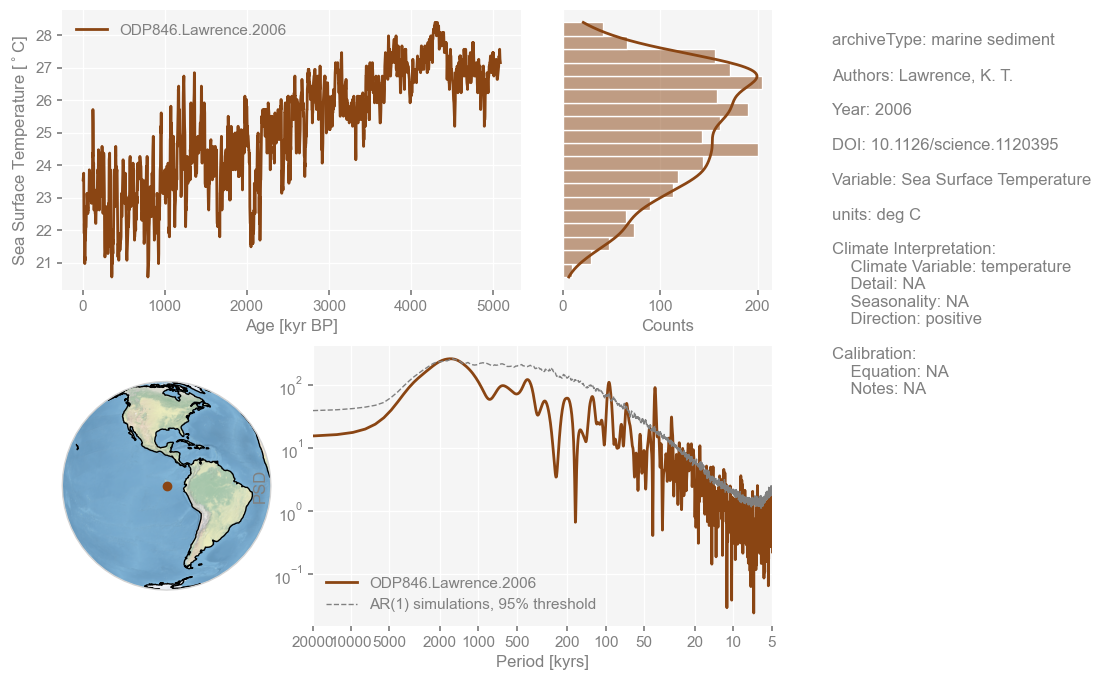

In [5]:
ts.dashboard(plt_kwargs={'marker':None})

Sea surface temperatures have decreased throughout the last 5M years, with cycles superimposed on the long-term cooling trend. The periodogram indicates significant periodicities at orbital time scales, which merits further investigation.

Since the age model was obtained by alignment of the benthic $\delta^{18}O$ to the LR04 curve, let's also load it into a `LipdSeries` object for comparison. The data is stored in the chron tables, which we indicate by using the `mode` parameter:

In [10]:
ts_benthic = D.to_LipdSeries(mode='chron')

extracting chronData...
extracting: ODP846.Lawrence.2006
Created time series: 3 entries
0 :  ODP846.Lawrence.2006 :  marine sediment :  depth
1 :  ODP846.Lawrence.2006 :  marine sediment :  age
2 :  ODP846.Lawrence.2006 :  marine sediment :  d18o
Enter the number of the variable you wish to use: 2


Let's rename our series and units:

In [11]:
ts_benthic.value_name = 'Benthic $\delta^{18}O$'
ts_benthic.value_unit = u'\u2030'

And do a simple plot of the benthic record:

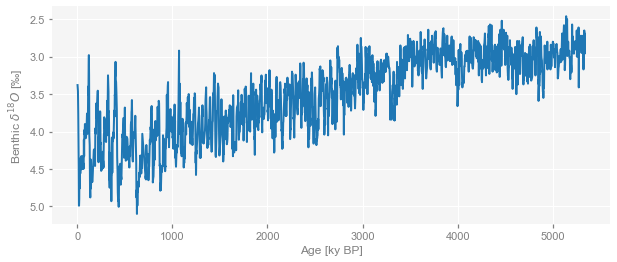

In [9]:
fig,ax = ts_benthic.plot(legend=False)
ax.invert_yaxis() #flip the axis by convention

The benthic $\delta^{18}O$ record displays:
* a long-term cooling trend ($\delta^{18}O$ gets more positive over time) characteristic of late Neogene and Quaternary and increasing ice volume
* shorter term shifts that represent the ice ages and that are used for the alignment of this benthic record with the benthic stack (LR04). 

Speaking of the LR04 record, let's load the benthic stack into a `Series` for comparison. The data is saved in csv format that can be loaded into a `Pandas DataFrame`.

In [7]:
df = pd.read_csv('./data/LR04.csv',skiprows=4)
df.head()

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03


And let's create a `Series` from this `DataFrame`:

In [8]:
lr04 = pyleo.Series(time=df.iloc[:,0],value=df.iloc[:,1],value_name='Benthic $\delta^{18}O$',value_unit=u'\u2030',
                   time_name='Age',time_unit='ky BP',label='LR04')

And plot it:

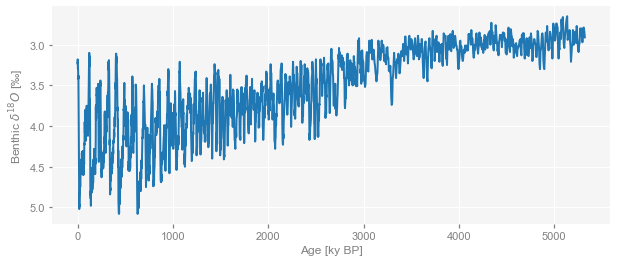

In [12]:
fig,ax = lr04.plot(legend=False) 
ax.invert_yaxis() #invert the y-axis as per standard usage

Let's plot the series together on a [stackplot](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#pyleoclim.core.ui.MultipleSeries.stackplot). This functionality is enabled through Pyleoclim's [`MultipleSeries` object](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#multipleseries-pyleoclim-multipleseries), which can be created from a list of `Series` (and by extension `LipdSeries`) objects.

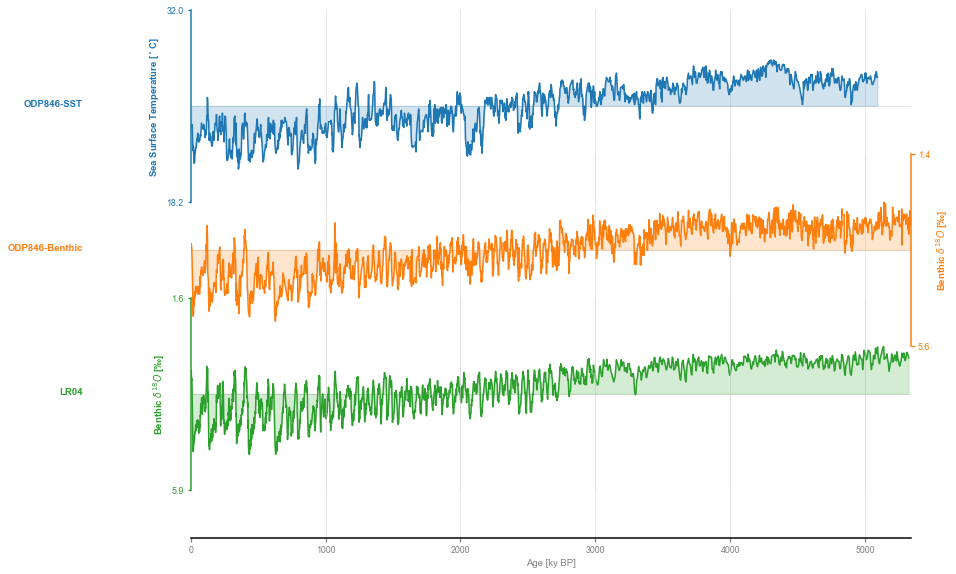

In [14]:
ms = pyleo.MultipleSeries([ts,ts_benthic,lr04])
fig,ax = ms.stackplot(figsize=[10,8],labels=['ODP846-SST','ODP846-Benthic','LR04'])
ax[1].invert_yaxis()
ax[2].invert_yaxis()

## <a name='analysis'>Spectral and Wavelet Analysis</a>

### <a name='benthic'>Benthic record</a>

Let's quickly examine the spectral content of the benthic record. Because the age model was obtained by aligning the record to the LR04 stack, which is orbitally tuned, we would expect to recover the orbital periodicities in the record.

Pyleoclim is capable of running both spectral and wavelet analysis, which give slightly different information about the timeseries. Both allow to examine the frequency content of a time series but wavelet analysis offers the added opportunity to examine the sationarity of that signal over time. Pyleoclim provides easy access to several methods, allowing you to explore the trade-offs of each method as well as the robustness of the signals to the statistical method. 

For spectral analysis, Pyleoclim offers a [variety of methods](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#pyleoclim.core.ui.Series.spectral) (e.g., MTM, Welch, Lomb-Scargle...). Some are more appropriate to evenly-spaced datasets (e.g., Lomb-Scargle) than others. Let's first plot the time difference between adjacent samples for the record. 

#### <a name='benthicexp'>Data exploration</a>

Text(0.5, 0, 'Age increments (ka)')

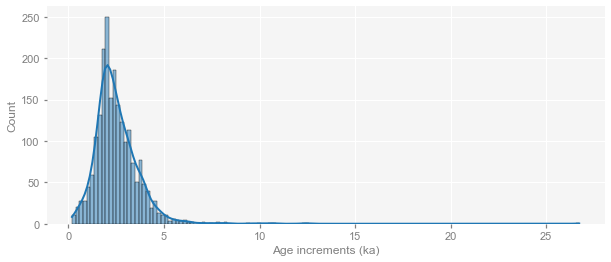

In [15]:
dt=np.diff(ts_benthic.time) # calculate the difference between adjacent time
fig, ax = plt.subplots(figsize=[10,4])
sns.histplot(dt,kde=True,ax=ax) 
ax.set_xlabel('Age increments (ka)')

The data is unevenly-spaced and therefore, traditional methods such as MTM, may not be appropriate for this dataset. Let's start with a Lomb-Scargle periodogram ([Lomb (1976)](https://link.springer.com/article/10.1007/BF00648343), Scargle ([1982](https://ui.adsabs.harvard.edu/abs/1982ApJ...263..835S/abstract),[1989](https://ui.adsabs.harvard.edu/abs/1989ApJ...343..874S/abstract))). 

We should also decide on any pre-processing steps. In this case, the long-term trend is confounding and should be removed prior to analysis. Pyleoclim offers several [detrending methods](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#pyleoclim.core.ui.Series.detrend): 
* linear
* constant (the mean is removed from the series)
* Filtering through a Savitzky-Golay filter and removal of the low-frequency component. 
* Empirical mode decomposition (removal of the last mode, which corresponds to the lowest-frequency signal). 

Of these, the last two seem to be the most appropriate for the data since the long-term cooling is not linear. Let's run both and compare the results.

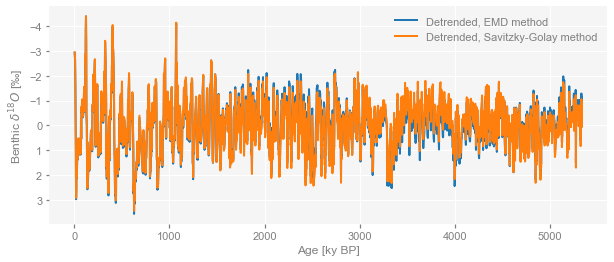

In [16]:
ts_benthic_emd = ts_benthic.detrend().standardize() #detrend using the EMD method, which is the default in Pyleoclim, and standardize
ts_benthic_emd.label = 'Detrended, EMD method' #label for plot
ts_benthic_sv = ts_benthic.detrend(method = 'savitzky-golay').standardize() #detrend using the Savitzky-Golay method and standardize
ts_benthic_sv.label = 'Detrended, Savitzky-Golay method' #label for plot
fig,ax = ts_benthic_emd.plot() #plot. 
ts_benthic_sv.plot(ax=ax)
ax.invert_yaxis()

The two detrending methods return very similar results, so we proceed with the default EMD method.

#### <a name='benthicana'> Analysis </a>

The Lomb-Scargle periodogram can then be obtained with the following line of code. We use method chaining to create a workflow that first detrend the time series using the default EMD method, standardize, run spectral analysis (note that here we ask for the Lomb Scargle method using a frequency method called Lomg Scargle after the REDFIT alogrithm of [Schulz and Mudelsee (2002)](https://www.sciencedirect.com/science/article/pii/S0098300401000449) and 5 overlapping segments), and perform significance testing using an AR1 ensemble. 

The Lomb-Scargle method implemented in Pyleoclim makes use of the Welch's overlapped segment averaging (WOSA) technique ([Welch, 1967](https://ieeexplore.ieee.org/document/1161901), [Schulz and Stattegger (1997)](https://www.sciencedirect.com/science/article/pii/S0098300497000873)). The parameter `n50` allows to set the number of segments with a 50% overlap. Feel free to change the settings and explore the effect of this parameter.   

For computational expediency, all results have been stored in the JSON format and can be reloaded from the next cell directly.

In [9]:
psd_benthic=ts_benthic.detrend().standardize().spectral(method='lomb_scargle', freq_method='lomb_scargle', settings={'n50':5,'standardize':False}).signif_test(number=1000,qs=[0.90,0.95,0.99])
pyleo.utils.jsonutils.PyleoObj_to_json(psd_benthic.copy(),'./data/psd_benthic.json')

Performing spectral analysis on individual series: 100%|█| 1000/1000 [12:24<00:0


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

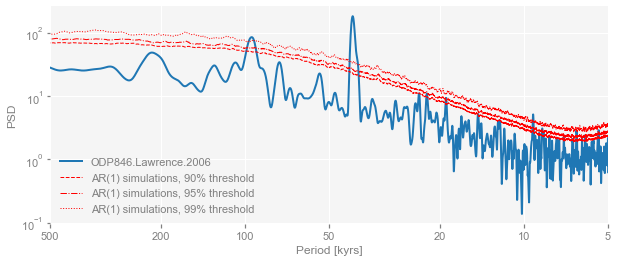

In [2]:
psd_benthic = pyleo.utils.jsonutils.json_to_PyleoObj('./data/psd_benthic.json','PSD')
psd_benthic.plot(xlim=[500,5]) #limit to 500k period

Unsurprisingly, the record displays periodicities around 40 kyr and 100 kyr. Why is this result not surprising? Remember that the age model was obtained by aligning the benthic record to the LR04 stack, which is itself tuned to those very Milankovitch periodicities. If anything, this proved that the Lomb-Scargle method can recover periodicities embedded in the record by construction. 

Another way to estimate the spectral density is to use the Weighted Wavelet Z-Transform ([WWZ](https://pyleoclim-util.readthedocs.io/en/master/utils/spectral/wwz_psd.html#utils-wwzpsd)) from [Foster (1996)](https://adsabs.harvard.edu/full/1996AJ....112.1709F) as implemented by [Zhu et al. (2019)](https://www.pnas.org/content/116/18/8728.short) for Pyleoclim, which is also appropriate for unevenly-spaced data. Note that this method is wavelet-based; we, therefore, compute the power spectral density (PSD) from the scalogram.

This opens two possibilities: (1) Run the 'wwz' method through `pyleoclim.Series.spectral` and/or (2) Run the 'wwz' method for wavelet analysis and compute the PSD from the stored scalograms. Which one should be used depends on the goal at hand.

To see why, let us have a look at the parameters attached to the `wwz` method as called through the [wavelet()](https://pyleoclim-util.readthedocs.io/en/master/utils/wavelet/wwz.html#utils-wwz) and [spectral()](https://pyleoclim-util.readthedocs.io/en/master/utils/spectral/wwz_psd.html#utils-wwzpsd) methods. One of the parameters is the decay constant `c`, which balances the time resolution and frequency resolution of the wavelet analysis. The smaller this constant is, the sharper the peaks. For spectral analysis, where the purpose is to find peaks, a smaller value for `c` is needed compared to wavelet analysis, where time-frequency localization is of the essence ([Foster (1996)](https://adsabs.harvard.edu/full/1996AJ....112.1709F), [Wu et al., 2007](https://www.pnas.org/doi/10.1073/pnas.0701020104)). Therefore, if the purpose is to identify spectral peaks (periodicites) in the record, it may be useful to run the `wwz` method through `spectral()` (method 1). If the purpose is to obtain the spectral slope only, then method 2 is more computationally efficient. 

Let's compare what happens with the two methods. Let's first compute the PSD from the `spectral()` mehod. **This calculation may take a few hours to run. You can skip the next cell and load from a saved JSON file in the next one.**

In [10]:
psd_benthic_wwz = ts_benthic.detrend().standardize().spectral(method='wwz',settings={'standardize':False}).signif_test(number=1000,qs=[0.90,0.95,0.99])
pyleo.utils.jsonutils.PyleoObj_to_json(psd_benthic_wwz.copy(),'./data/psd_benthic_wwz.json')

Performing spectral analysis on individual series: 100%|█| 1000/1000 [3:48:59<00


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

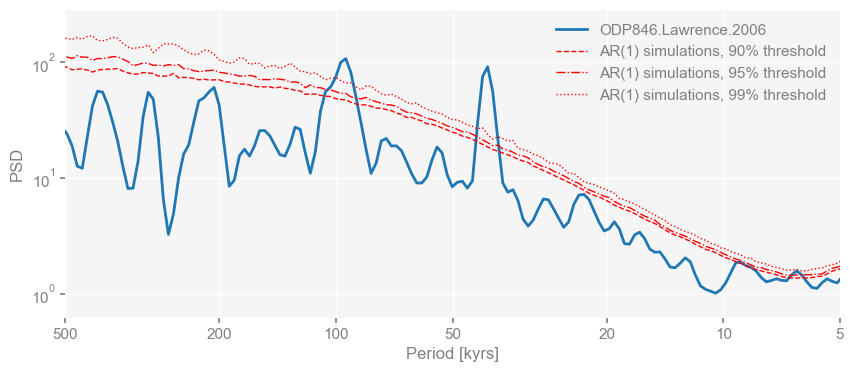

In [6]:
psd_benthic_wwz = pyleo.utils.jsonutils.json_to_PyleoObj('./data/psd_benthic_wwz.json', 'PSD')
psd_benthic_wwz.plot(xlim=[500,5]) #limit to 500k period

The PSD obtained from WWZ method agrees remarkably well with the PSD obtained using Lomb-Scargle. We will compare the two methods on the same plot after we obtain the PSD using the scalograms from `wavelet()`. To do so, you need to set the `export_scal` parameter to `True`. 

**Note that this computation takes some time and the resulting file is ~500 Mb, which is larger than what can be stored on GitHub. Please used the next second cell to download the data from Dropbox.**

In [13]:
scal_benthic_wwz=ts_benthic.detrend().standardize().wavelet(method='wwz',settings={'standardize':False}).signif_test(number=1000, export_scal=True)
pyleo.utils.jsonutils.PyleoObj_to_json(scal_benthic_wwz.copy(),'./data/scal_benthic_wwz.json')

Performing wavelet analysis on individual series: 100%|█| 1000/1000 [1:28:51<00:


In [7]:
!wget -O scal_benthic_wwz.json https://www.dropbox.com/s/9ia8ivt1gqqwao1/scal_benthic_wwz.json?dl=0

--2022-09-14 13:26:06--  https://www.dropbox.com/s/9ia8ivt1gqqwao1/scal_benthic_wwz.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9ia8ivt1gqqwao1/scal_benthic_wwz.json [following]
--2022-09-14 13:26:07--  https://www.dropbox.com/s/raw/9ia8ivt1gqqwao1/scal_benthic_wwz.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb901fd3e56393c59ca89e224dd.dl.dropboxusercontent.com/cd/0/inline/Bs9gT2dy5YdQ-AIo7ljpPWqPFVnwOT84Ad_krUnOKzWHF-w-8glohJfzZGEueeOp3ddGi0cT3UxVrS-D6iVqCk94RPfnH7VbWKBkN174EIaKXdJqvaLz3xnWwk565CeRBHCp3mmau8kl2hVxZijO-YgPGmfrjkGGBo560cCj06ii8A/file# [following]
--2022-09-14 13:26:07--  https://ucb901fd3e56393c59ca89e224dd.dl.dropboxusercontent.com/cd/0/inline/Bs9gT2dy5YdQ-AIo7ljpPWqPFVnwOT84Ad_krUnOKzWHF-w-8glohJfzZGEueeOp3ddGi0cT3UxV

(<Figure size 1000x800 with 2 Axes>,
 <AxesSubplot:title={'center':'ODP846.Lawrence.2006 scalogram (WWZ) with 95% threshold'}, xlabel='Age [ky BP]', ylabel='Scale [kyrs]'>)

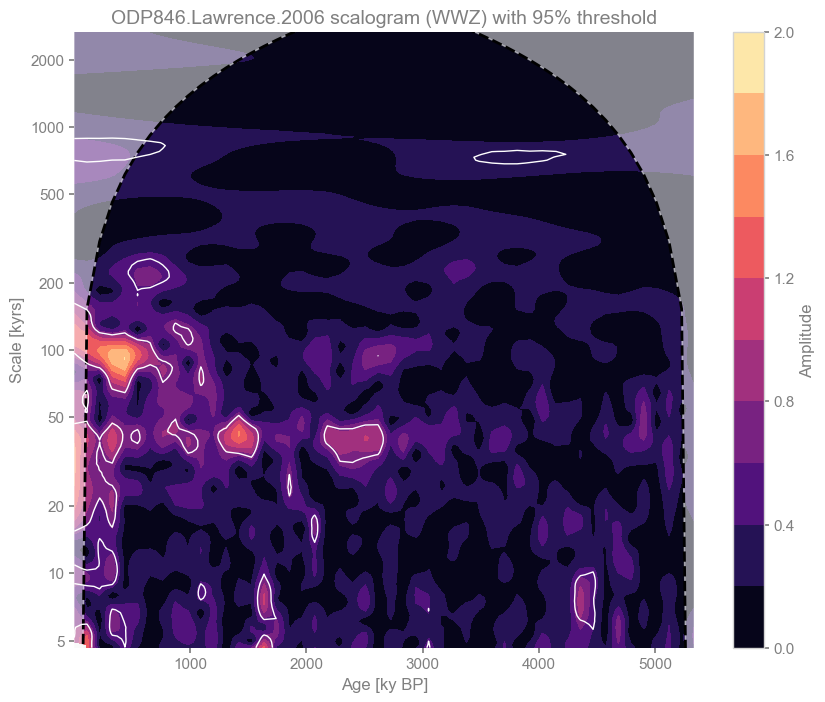

In [8]:
scal_benthic_wwz = pyleo.utils.jsonutils.json_to_PyleoObj('scal_benthic_wwz.json', 'Scalogram')
scal_benthic_wwz.plot()

The scalogram reveals the non-stationary character of the periodicities seen in spectral analysis and offers additional information related to the well-known mid-Pleistocene transition from a "41 kyr world" to a "100 kyr world" somewhere around 0.8 Ma ([Paillard (2001)](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2000RG000091)). There is also a drop in power after 3 Ma, which could be a climate signal or due to core resolution/alignment. The LR04 stack is noisier since fewer records are part of the composite over that time period. In other words, the noise to signal ratio may prevent any climate-related cyclicities from being identified. 

Next, let's compute the PSD from the scalogram and plot it.  

Performing spectral analysis on individual series: 100%|█| 1000/1000 [00:00<00:0


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

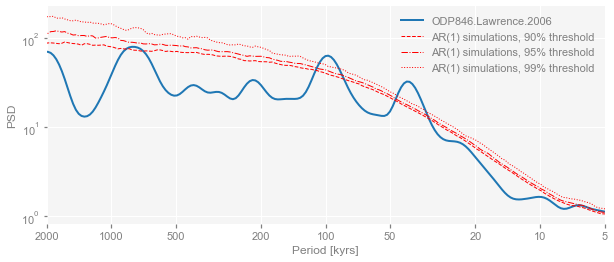

In [16]:
psd_benthic_wwz_fromscal = ts_benthic.detrend().standardize().spectral(method='wwz',scalogram=scal_benthic_wwz).signif_test(qs=[0.90,0.95,0.99], scalogram=scal_benthic_wwz)
psd_benthic_wwz_fromscal.plot()

Note the effect of `c` on the periodogram: the lower resolution creates a smoother PSD, with peaks less sharply defined. 

Let's compare the Lomb-Scargle and WWZ method. To this end, we recompute the Lomb-Scargle periodogram using the default frequency vector:

In [17]:
psd_benthic_default_freq=ts_benthic.detrend().standardize().spectral(method='lomb_scargle', settings={'n50':5,'standardize':False}).signif_test(number=1000,qs=[0.90,0.95,0.99])
pyleo.utils.jsonutils.PyleoObj_to_json(psd_benthic_default_freq.copy(),'./data/psd_benthic_default_freq.json')

Performing spectral analysis on individual series: 100%|█| 1000/1000 [00:19<00:0


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

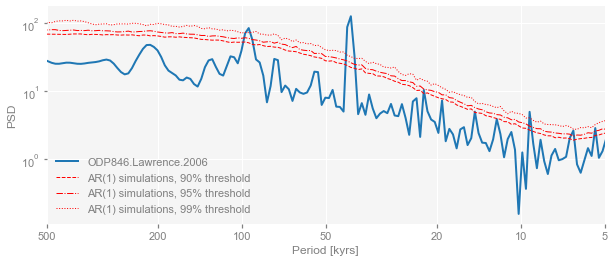

In [10]:
psd_benthic_default_freq = pyleo.utils.jsonutils.json_to_PyleoObj('./data/psd_benthic_default_freq.json', 'PSD')
psd_benthic_default_freq.plot(xlim=[500,5]) #limit to 500k period

We can plot the two spectra obtained from the wwz and Lomb-Scargle methods on the same figure:

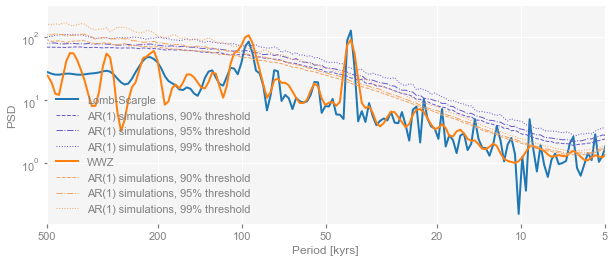

In [19]:
fig,ax = psd_benthic_default_freq.plot(xlim=[500,5], signif_clr='slateblue') #limit to 500k period and change the color of the significance line. 
psd_benthic_wwz.plot(ax=ax, signif_clr='sandybrown',xlim=[500,5]) #change the color of the significance line. 
current_handles, current_labels = plt.gca().get_legend_handles_labels() #get the information about the legend
current_labels[0] = 'Lomb-Scargle' # change label of the first entry to describe the method rather than the record name
current_labels[-4] = 'WWZ' # change label of the second to last entry to describe the method rather than the record name
plt.legend(current_handles,current_labels) ##replace legend entries

This plot highlights the remakable agreement between the two methods.

Pyleoclim can also create a [summary plot](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#pyleoclim.core.ui.Series.summary_plot) of the wavelet and spectral analysis:

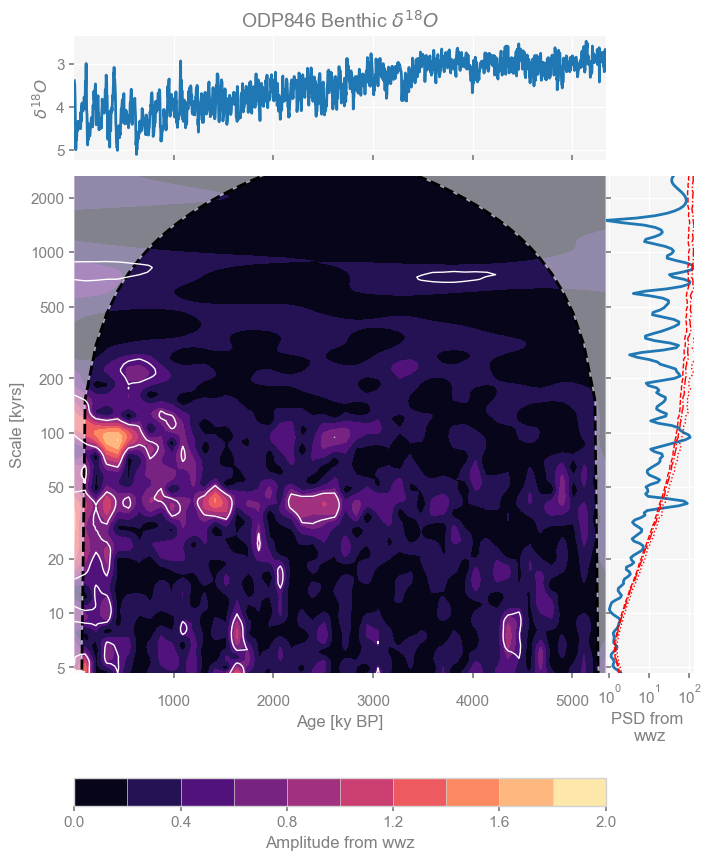

In [12]:
fig,ax = ts_benthic.summary_plot(psd=psd_benthic_wwz,scalogram=scal_benthic_wwz, value_label = '$\delta^{18}O$',
                                title = 'ODP846 Benthic $\delta^{18}O$',
                                ts_plot_kwargs = {'legend':False}) #change the label so it fits on the plot
ax['ts'].invert_yaxis() #invert the y-axis for the timeseries plot (print ax to figure out the 'ts' label)

#### <a name='LR04'>Comparison with Benthic LR04 stack </a>

The loss of power before 3 million years is intriguing and merits further investigation. There are two possible (and non mutually exclusive) explanations: (1) The orbital signal has a weaker impact on climate, (2) the noise to signal ratio is preventing detection. The LR04 stack is composed of 57 globally distributed records. However, most of the high-resolution records cover the last 2 million years (Lisiecki and Raymo, 2005), making the alignment between 3-5 Ma more difficult.

Let's compute the scalogram for LR04:

In [21]:
scal_LR04_wwz=lr04.detrend().standardize().wavelet(method='wwz',settings={'standardize':False}).signif_test(number=1000)
pyleo.utils.jsonutils.PyleoObj_to_json(scal_LR04_wwz.copy(),'./data/scal_LR04_wwz.json')

Performing wavelet analysis on individual series: 100%|█| 1000/1000 [1:37:58<00:


(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'LR04 scalogram with 95% threshold'}, xlabel='Age [ky BP]', ylabel='Scale [kyrs]'>)

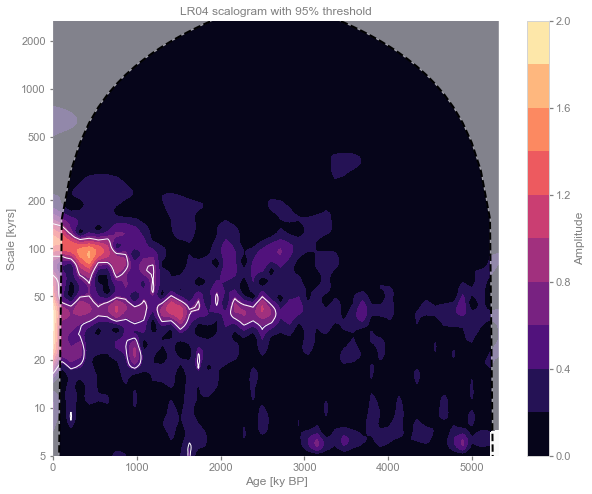

In [22]:
scal_LR04_wwz = pyleo.utils.jsonutils.json_to_PyleoObj('./data/scal_LR04_wwz.json', 'Scalogram')
scal_LR04_wwz.plot()

The stack displays strong periodicitied in the 100 kyr and 40 kyr band up to about 3 Ma. Despite being oribitally tuned, the method cannot accurately capture the 40 kyr periodicities from the early part of the record. We would, therefore, not expect to see them in the ODP846 record either. 

### <a name='planktonic'> Planktonic record </a>

#### <a name='planktonicexp'> Data exploration </a>

Let's repeat our process with the planktonic data. In this case, the variations in SST were not aligned to the LR04 stack and are therefore not orbitally tuned. However, the data is still unevenly-spaced:

Text(0.5, 0, 'Age increments (ka)')

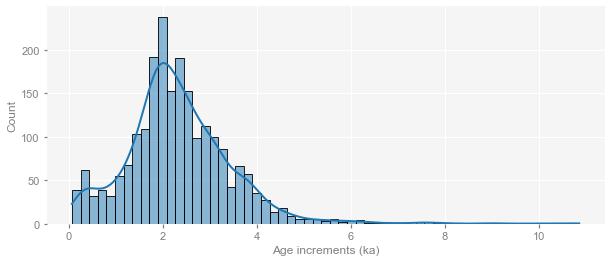

In [23]:
dt=np.diff(ts.time)
fig, ax = plt.subplots(figsize=[10,4])
sns.histplot(dt,kde=True,ax=ax)
ax.set_xlabel('Age increments (ka)')

Again, let's look at detrending methods for pre-processing:

<AxesSubplot:xlabel='Age [kyr BP]', ylabel='Sea Surface Temperature [$^\\circ$C]'>

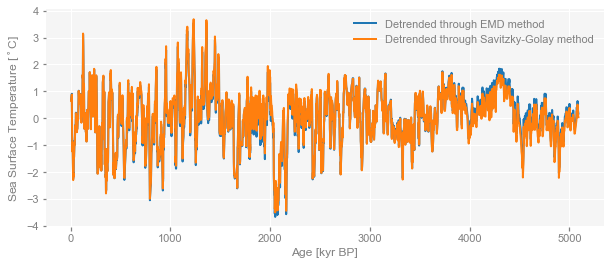

In [25]:
ts_emd = ts.detrend().standardize()
ts_emd.label = 'Detrended through EMD method'
ts_sv = ts.detrend(method = 'savitzky-golay').standardize()
ts_sv.label = 'Detrended through Savitzky-Golay method'
fig,ax = ts_emd.plot()
ts_sv.plot(ax=ax)

Once again, the two are equivalent and we will proceed with the default EMD method. 

#### <a name=planktonicana> Analysis </a>

Let's obtain the Lomb-Scargle periodogram:

In [26]:
psd=ts.detrend().standardize().spectral(method='lomb_scargle', freq_method='lomb_scargle', settings={'n50':5,'standardize':False}).signif_test(number=1000,qs=[0.90,0.95,0.99])
pyleo.utils.jsonutils.PyleoObj_to_json(psd.copy(),'./data/psd.json')

Performing spectral analysis on individual series: 100%|█| 1000/1000 [14:05<00:0


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

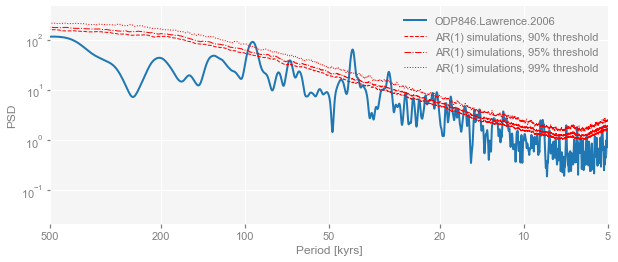

In [12]:
psd = pyleo.utils.jsonutils.json_to_PyleoObj('./data/psd.json', 'PSD')
psd.plot(xlim=[500,5])

The record displays significant periodicities around and 100 kyr and singificant peaks in the precessional and obliquity band (23-40 kyr). 

Let's examine the robustness of these findings with the WWZ method. As we have done with the benthic record, let's first compute the PSD from the `spectral` method. 

In [28]:
psd_wwz = ts.detrend().standardize().spectral(method='wwz',settings={'standardize':False}).signif_test(number=1000,qs=[0.90,0.95,0.99])
pyleo.utils.jsonutils.PyleoObj_to_json(psd_wwz.copy(),'./data/psd_wwz.json')

Performing spectral analysis on individual series: 100%|█| 1000/1000 [1:48:47<00


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

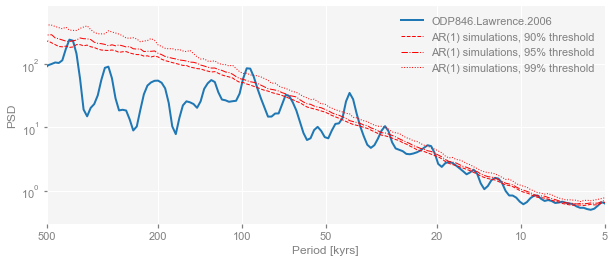

In [13]:
psd_wwz = pyleo.utils.jsonutils.json_to_PyleoObj('./data/psd_wwz.json', 'PSD')
psd_wwz.plot(xlim=[500,5]) #limit to 500k period

And let's compute the scalogram to look at the intermittence of the periodicities:

**Note that this calculation takes some time to complete. You can download the data in the next cell.**

In [9]:
scal_wwz=ts.detrend().standardize().wavelet(method='wwz',settings={'standardize':False}).signif_test(number=1000, export_scal=True)
pyleo.utils.jsonutils.PyleoObj_to_json(scal_wwz.copy(),'./data/scal_wwz.json')

Performing wavelet analysis on individual series: 100%|█| 1000/1000 [1:25:13<00:


**The resulting scalogram object is over the size limit for GitHub. Use the cell below to download the pre-tun version**:

In [10]:
!wget -O scal_wwz.json https://www.dropbox.com/s/7sc6pt2ly2j0u92/scal_wwz.json?dl=0

--2022-06-01 08:59:50--  https://www.dropbox.com/s/7sc6pt2ly2j0u92/scal_wwz.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7sc6pt2ly2j0u92/scal_wwz.json [following]
--2022-06-01 08:59:51--  https://www.dropbox.com/s/raw/7sc6pt2ly2j0u92/scal_wwz.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4cd3daf1941bf98cf874b47cef.dl.dropboxusercontent.com/cd/0/inline/BmaUxkhViXwg56HPxgtxAA_aSQhdnmxLW_xLKDdTuZhz34SGwViwB7pooyH5xHsOzRKHjArqHVKbx411_Wx7H2JPWbllWJ-APg52GScMAcjGMftSTignYFLoT2_aQnNvaaRuB9yLBOU7tGvfw5tYdpnUSRoN7D3W5216GprRa3lfpA/file# [following]
--2022-06-01 08:59:51--  https://uc4cd3daf1941bf98cf874b47cef.dl.dropboxusercontent.com/cd/0/inline/BmaUxkhViXwg56HPxgtxAA_aSQhdnmxLW_xLKDdTuZhz34SGwViwB7pooyH5xHsOzRKHjArqHVKbx411_Wx7H2JP

(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'ODP846.Lawrence.2006 scalogram with 95% threshold'}, xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>)

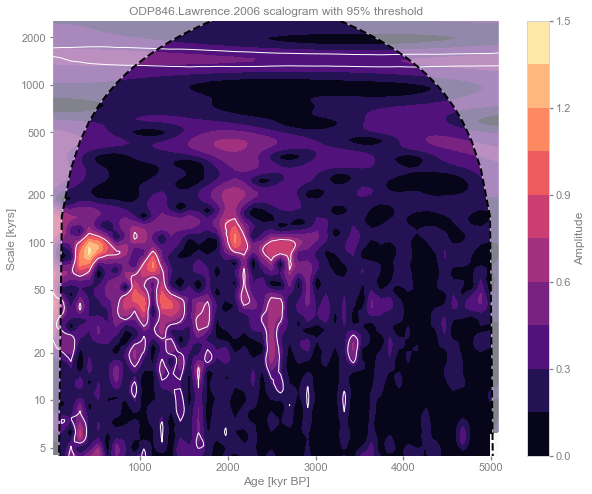

In [14]:
scal_wwz = pyleo.utils.jsonutils.json_to_PyleoObj('scal_wwz.json', 'Scalogram')
scal_wwz.plot()

The scalogram displays significant and intermittent periodicities in the 100 kyr band between 0 and 3 Ma (beyond the mid-Pleistocene transmission). There is also significant power between 20-40 kyr throughout the last 3 Ma. 

Let's compute the PSD from the scalogram:

Performing spectral analysis on individual series: 100%|█| 1000/1000 [00:00<00:0


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

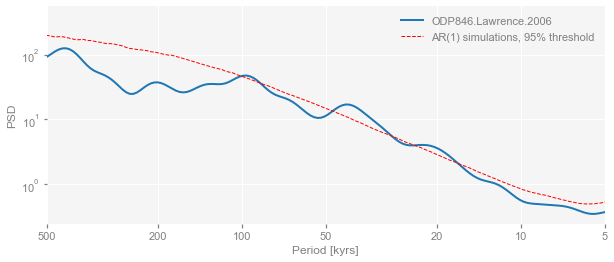

In [13]:
psd_wwz_fromscal = ts.detrend().standardize().spectral(method='wwz',scalogram=scal_wwz).signif_test(number=1000, scalogram=scal_wwz)
psd_wwz_fromscal.plot(xlim=[500,5])

Notice the effect of the `c` parameter. The PSD is thoroughly smoothed out when obtained from the scalograms directly. 

Let's recompute the PSD with the Lomb-Scargle method and the same frequency vector as we used for the wwz method for direct comparison: 

In [15]:
psd_default_freq=ts.detrend().standardize().spectral(method='lomb_scargle', settings={'n50':5,'standardize':False}).signif_test(number=1000,qs=[0.90,0.95,0.99])
pyleo.utils.jsonutils.PyleoObj_to_json(psd_default_freq.copy(),'./data/psd_default_freq.json')

Performing spectral analysis on individual series: 100%|█| 1000/1000 [00:21<00:0


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

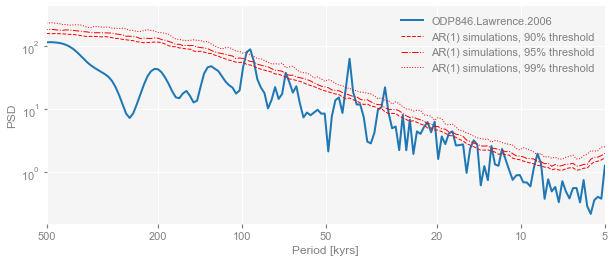

In [15]:
psd_default_freq = pyleo.utils.jsonutils.json_to_PyleoObj('./data/psd_default_freq.json', 'PSD')
psd_default_freq.plot(xlim=[500,5])

The PSD obtained with the WWZ method shows the significant periodicites at 100 kyr, 40 kyr and 23 kyr. Let's plot the two PSDs on the same figure for comparison.

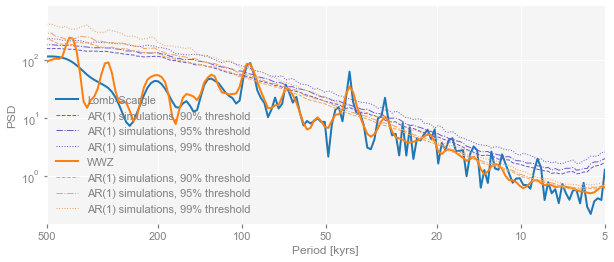

In [19]:
fig,ax = psd_default_freq.plot(xlim=[500,5], signif_clr='slateblue') #limit to 500k period and change the color of the significance line. 
psd_wwz.plot(ax=ax, signif_clr='sandybrown',xlim=[500,5]) #change the color of the significance line. 
current_handles, current_labels = plt.gca().get_legend_handles_labels() #get the information about the legend
current_labels[0] = 'Lomb-Scargle' # change label of the first entry to describe the method rather than the record name
current_labels[-4] = 'WWZ' # change label of the second to last entry to describe the method rather than the record name
plt.legend(current_handles,current_labels) ##replace legend entries

Again, the two methods agree remarkably well. 

##### <a name='age'> Effect of Age Uncertainty </a>

Age model uncertainty can results in shifted age-depth relationship that may affect the spectrum. If age models are present in the LiPD file, Pyleoclim can help you identify spurious peaks. The first step is to bring the age model ensemble table on the paleoclimate variable depth scale:

In [10]:
sst_ens = ts.chronEnsembleToPaleo(D)

This command created a [`pyleoclim.EnsembleSeries`](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#ensembleseries-pyleoclim-ensembleseries) object. Most of the methods applicable to this object are similar to Series but tailored to take into account the ensemble. For instance, the basic plot function plots a handful of the ensemble members:

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [kyr BP]', ylabel='Sea Surface Temperature [$^\\circ$C]'>)

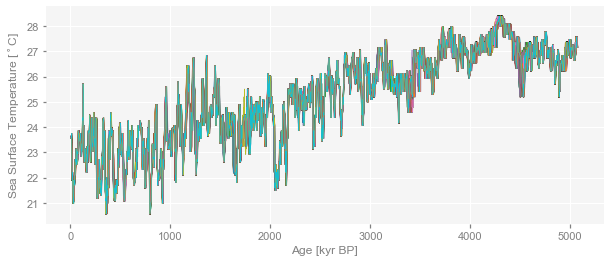

In [21]:
sst_ens.plot(linewidth=0.5)

The envelope plot is often more practical to look at ensembles. However, make sure that the plot only encompasses the common period represented in every member. Don't worry, Pyleoclim has a function for this called [`common_time`](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#pyleoclim.core.ui.MultipleSeries.common_time). 

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [kyr BP]', ylabel='Sea Surface Temperature [$^\\circ$C]'>)

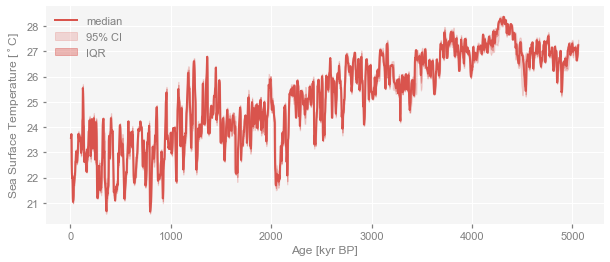

In [22]:
sst_ens.common_time().plot_envelope()

Let's run spectral analysis. For speed, we will only use the Lomb-Scargle method. For consistency, we will also work with the same frequency vector as for the original analysis, which we can directly obtain from the object:

In [27]:
freq = psd.frequency #obtain the frequency vector from the PSD object created after spectral analysis. 
psd_ens=sst_ens.spectral(settings={'freq':freq,'standardize':False})
pyleo.utils.jsonutils.PyleoObj_to_json(psd_ens.copy(),'./data/psd_ens.json')

Performing spectral analysis on individual series: 100%|█| 1000/1000 [12:43<00:0


We can now plot the resulting ensemble PSD (make sure you download the file if you did not run the cell above):

In [2]:
!wget -O psd_ens.json https://www.dropbox.com/s/ax9smkqqpsvz7c2/psd_ens.json?dl=0

--2022-06-01 19:07:52--  https://www.dropbox.com/s/ax9smkqqpsvz7c2/psd_ens.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ax9smkqqpsvz7c2/psd_ens.json [following]
--2022-06-01 19:07:53--  https://www.dropbox.com/s/raw/ax9smkqqpsvz7c2/psd_ens.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4175d93860d03aa9a1d37dd302.dl.dropboxusercontent.com/cd/0/inline/Bmadc0ph1VLXG2_so-jiKibtcqwyw73y2b1aZLLoxHa-IUXmI3Fk2qachhsz5DekTt7bbwxjqozA-2bNiWe7Ie8fScQ2tUGbTP3e-uu7PLXc24p4rw0upQy2lFTabkciZRBmdCFLYxAqpoRj_Jv32EV1kPJZBH-7T7LhlQerqfzZtQ/file# [following]
--2022-06-01 19:07:53--  https://uc4175d93860d03aa9a1d37dd302.dl.dropboxusercontent.com/cd/0/inline/Bmadc0ph1VLXG2_so-jiKibtcqwyw73y2b1aZLLoxHa-IUXmI3Fk2qachhsz5DekTt7bbwxjqozA-2bNiWe7Ie8fScQ

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyr BP]', ylabel='Amplitude'>)

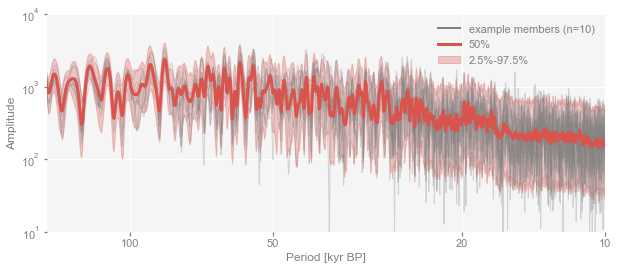

In [3]:
psd_ens = pyleo.utils.jsonutils.json_to_PyleoObj('psd_ens.json', 'MultiplePSD')
psd_ens.plot_envelope(xlim=[150,10],ylim=[10,1e4])

Most of the low periodicity noise observed originally is smoothed out in the median ensemble, which is not surprising. The record retains orbital periodicity (40-100kyr) that is expressed in most of the age models. 

## <a name='sol'> Relationship to Insolation </a>

Let's examine the relation between the orbital periodicities observed in the SST record
Given that the signal only exhibits singificant power in the 0-3MA, let's slice the record

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [kyr BP]', ylabel='Sea Surface Temperature [$^\\circ$C]'>)

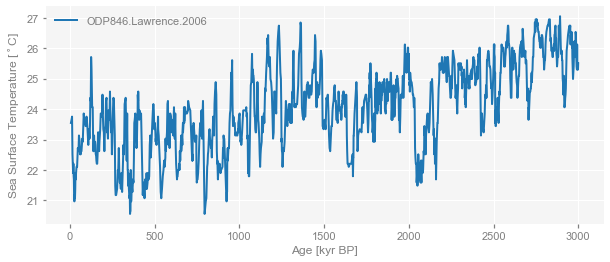

In [17]:
ts_slice = ts.slice([0,3000])
ts_slice.plot()

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [kyr BP]', ylabel='Sea Surface Temperature [$^\\circ$C]'>)

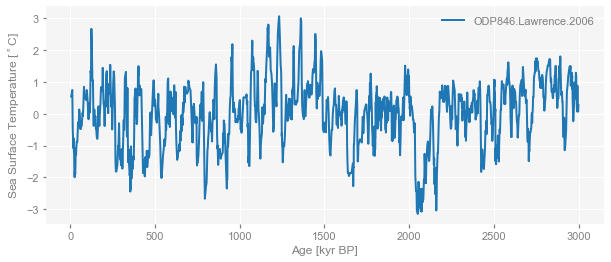

In [18]:
ts_slice.detrend().standardize().plot()

**Hypothesis 1**: The periodic signals are driven by insolation at 5S, where the record is located.


Let us use ClimLab to obtain the insolation at 5S.

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [ky BP]', ylabel='Insolation at 5 $^\\circ$S [$W/m^{2}$]'>)

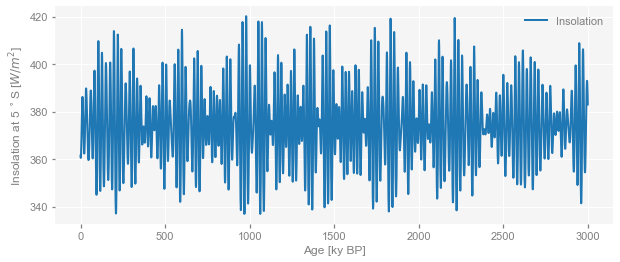

In [19]:
# array with specified kyears
years = np.linspace(-3000, 0, 3001)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

# insolation values for past 3 Myears at 5S at summer solstice (day 172)
S5 = daily_insolation(lat=-5, day=172, orb=orb)

# put in a Pyleoclim.Series object
sol = pyleo.Series(time=-years,value=S5,value_name='Insolation at 5 $^\circ$S',value_unit='$W/m^{2}$',
                   time_name='Age',time_unit='ky BP',label='Insolation')

sol.plot()

Since the record is evenly-spaced, we can use spectral methods appropriate for evenly-spaced time series such as MTM for spectral analysis and the continous wavelet transform. For the later, we use the method by Torrence and Compo (1998):

In [15]:
psd_sol=sol.standardize().spectral(method='mtm',settings={'standardize':False}).signif_test(number=1000,qs=[0.90,0.95,0.99])
pyleo.utils.jsonutils.PyleoObj_to_json(psd_sol.copy(),'./data/psd_sol.json')

Performing spectral analysis on individual series: 100%|█| 1000/1000 [01:46<00:0


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

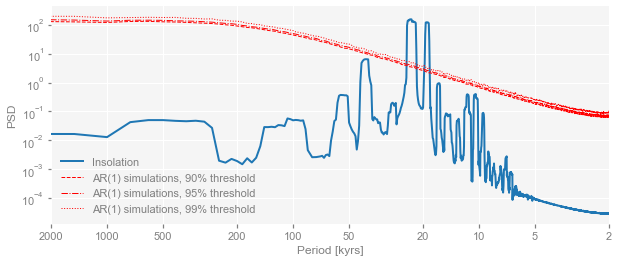

In [20]:
psd_sol = pyleo.utils.jsonutils.json_to_PyleoObj('./data/psd_sol.json', 'PSD')
psd_sol.plot()

In [18]:
scal_sol = sol.standardize().wavelet(method='cwt',settings={'standardize':False}).signif_test(number=1000)
pyleo.utils.jsonutils.PyleoObj_to_json(scal_sol.copy(),'./data/scal_sol.json')

Performing wavelet analysis on individual series: 100%|█| 1000/1000 [01:49<00:00


(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Insolation scalogram with 95% threshold'}, xlabel='Age [ky BP]', ylabel='Scale [kyrs]'>)

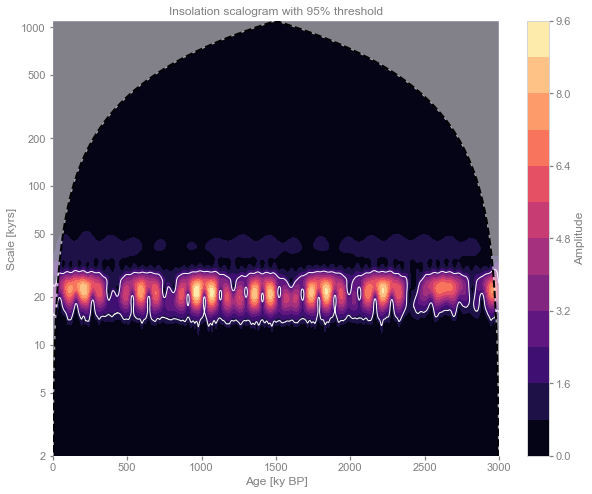

In [21]:
scal_sol = pyleo.utils.jsonutils.json_to_PyleoObj('./data/scal_sol.json', 'Scalogram')
scal_sol.plot()

Bother spectral and wavelet analysis shows high, significant power in the 23-kyr band, which corresponds to the precessional cycle. Let's run coherence analysis between the SST record and insolation at 5S:

In [24]:
coh = ts_slice.detrend().standardize().wavelet_coherence(sol.standardize(), method='wwz',settings={'standardize':False}).signif_test(number=1000)
pyleo.utils.jsonutils.PyleoObj_to_json(coh.copy(),'./data/coh.json')

Performing wavelet coherence on surrogate pairs: 100%|█| 1000/1000 [2:52:45<00:0


(-6.0, 3.0)

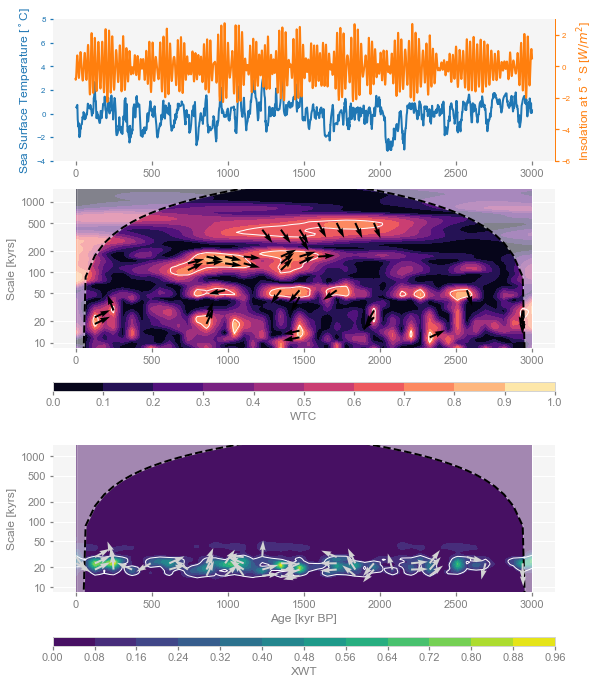

In [8]:
coh = pyleo.utils.jsonutils.json_to_PyleoObj('./data/coh.json', 'Coherence')
fig, ax = coh.dashboard()
ax['ts1'].set_ylim([-4,8]) #offset the lines
ax['ts2'].set_ylim([-6,3]) #offset the lines

XWT (cross-wavelet transform) informs about areas where there is high common power between the two series. The analysis reveals high common power in the precession band (~23kyr) but the phase angles are irregular. This is not surprising given the spectral analysis on the age ensembles, which shows large effects of age uncertainty at 20kyr scales (compared to 40-100kyr). Even if there was a regular behavior, the age uncertainty prevents us from capturing it in the analysis. 

WTC (wavelet transform coherence) shows areas of common behavior between the two time series even if there is low power. The analysis reveals coherence in the 23kyr, 40kyr, 100kyr and 400kyr bands, consistent with orbital forcing of climate. The phase angles in the two upper bands are also regular and show and an in-phase behavior in the eccentrivity band (particularly ca 1Ma) and nearly in phase quadrature in the 400kyr band. 

Let's examine whether insolation at 65N has a greater impact on the SST record. 

**Hypothesis 2**: The periodic signals are driven by insolation at 65N.

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [ky BP]', ylabel='Insolation at 65 $^\\circ$N [$W/m^{2}$]'>)

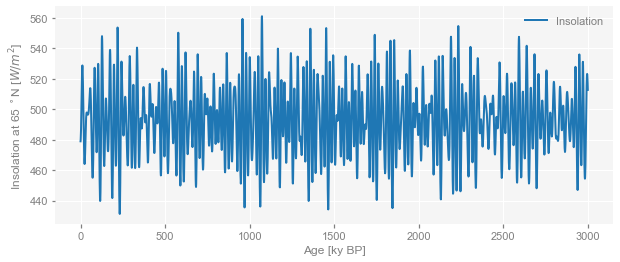

In [25]:
# insolation values for past 3 Myears at 65N at summer solstice (day 172)
S65 = daily_insolation(lat=65, day=172, orb=orb)

# put in a Pyleoclim.Series object
sol65 = pyleo.Series(time=-years,value=S65,value_name='Insolation at 65 $^\circ$N',value_unit='$W/m^{2}$',
                   time_name='Age',time_unit='ky BP',label='Insolation')

sol65.plot()

In [21]:
psd_sol65=sol65.standardize().spectral(method='mtm',settings={'standardize':False}).signif_test(number=1000,qs=[0.90,0.95,0.99])
pyleo.utils.jsonutils.PyleoObj_to_json(psd_sol.copy(),'./data/psd_sol65.json')

Performing spectral analysis on individual series: 100%|█| 1000/1000 [01:50<00:0


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

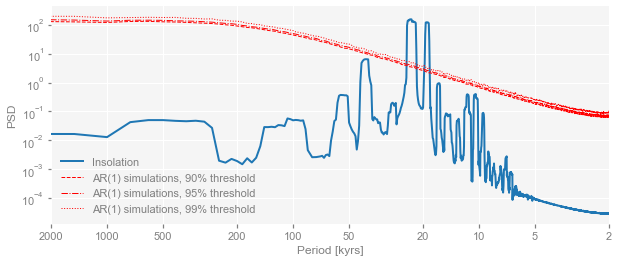

In [26]:
psd_sol65 = pyleo.utils.jsonutils.json_to_PyleoObj('./data/psd_sol65.json', 'PSD')
psd_sol65.plot()

In [23]:
scal_sol65 = sol65.standardize().wavelet(method='cwt').signif_test(number=1000)
pyleo.utils.jsonutils.PyleoObj_to_json(scal_sol65.copy(),'./data/scal_sol65.json')

Performing wavelet analysis on individual series: 100%|█| 1000/1000 [01:54<00:00


(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Insolation scalogram with 95% threshold'}, xlabel='Age [ky BP]', ylabel='Scale [kyrs]'>)

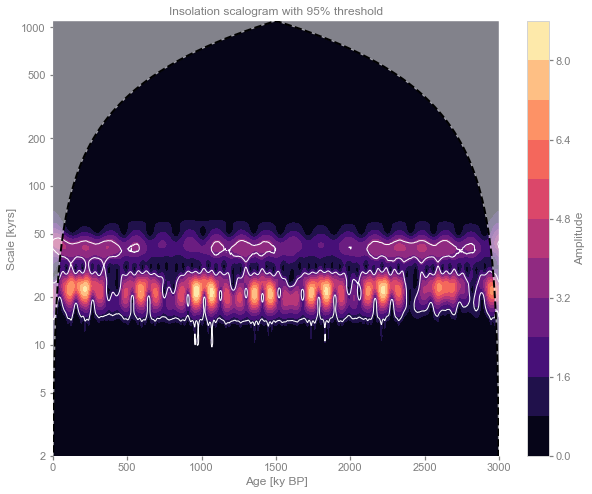

In [27]:
scal_sol65 = pyleo.utils.jsonutils.json_to_PyleoObj('./data/scal_sol65.json', 'Scalogram')
scal_sol65.plot()

Spectral and wavelet analysis also shows high, significant power in the precession band. Unlike insolation at 5S, there is stronger power in the obliquity band.

In [28]:
coh65 = ts_slice.detrend().standardize().wavelet_coherence(sol65.standardize(), method='wwz',settings={'standardize':False}).signif_test(number=1000)
pyleo.utils.jsonutils.PyleoObj_to_json(coh65.copy(),'./data/coh65.json')

Performing wavelet coherence on surrogate pairs: 100%|█| 1000/1000 [4:03:32<00:0


(-6.0, 3.0)

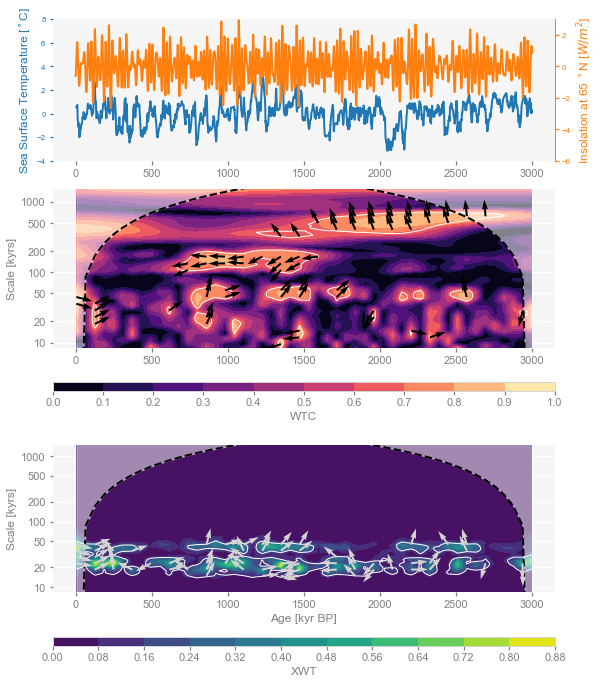

In [9]:
coh65 = pyleo.utils.jsonutils.json_to_PyleoObj('./data/coh65.json', 'Coherence')
fig, ax = coh65.dashboard()
ax['ts1'].set_ylim([-4,8]) #offset the lines
ax['ts2'].set_ylim([-6,3]) #offset the lines

The XWT analysis reveals high common power in the precession band (~23kyr) and interminently in the obliquity band (~40kyr) but the phase angles are irregular, which we again interpret as a consequence of age uncertainty 

The WTC analysis reveals coherence in the 40kyr, 100kyr and 400kyr bands, consistent with orbital forcing of climate. The phase angles in the two upper bands are also regular. Interestingly, it shows an anti-phased behavior in the 100kyr band. This should not be interpreted as a 50kyr lag of sea surface response to the forcing since the eccentricity signal in insolation (the forcing) is not significant. 



## <a name='conclusion'> Conclusion </a>

In this notebook, we demonstrate the use of the Pyleoclim package for spectral and wavelet analysis using a deep sea record from the Eastern Equatorial Pacific. We first confirmed the strong relationship between the benthic $\delta^{18}O$ record and orbital cycle, which is note surprising since the age model for this record was obtained through alignment to the orbitally-tuned LR04 stack.

The independently obtained SST record also exhbitis significant (despite age uncertainty) power in the orbital band. It is interesting to note that the peaks are not well defined around the precession and obliquity cycles, but rather the periodogram shows several peaks within the 20-40kyr band in addition to the 100-kyr eccentricity cycle.

Cross-wavelet analysis shows high power in the precession band but age model uncertainties preclude any meaningful interpretation of the relative phasing. 

## <a name='ref'> References </a>

Khider, D., Ahn, S., Lisiecki, L. E., Lawrence, C. E., & Kienast, M. (2017). The Role of Uncertainty in Estimating Lead/Lag Relationships in Marine Sedimentary Archives: A Case Study From the Tropical Pacific. Paleoceanography, 32(11), 1275-1290. 

Lawrence, K. T., Liu, Z. H., & Herbert, T. D. (2006). Evolution of the eastern tropical Pacific through Plio-Pleistocne glaciation. Science, 312(5770), 79-83.

Lin, L., Khider, D., Lisiecki, L. E., & Lawrence, C. E. (2014). Probabilistic sequence alignment of stratigraphic records. Paleoceanography, 29(976-989), 976-989. 

Lisiecki, L. E., & Raymo, M. E. (2005). A Pliocene-Pleistocene stack of 57 globally distributed benthic δ18O records. Paleoceanography, 20(PA1003). 

Lomb, N. R. (1976). Least-squares frequency analysis of unequally spaced data. Astrophysics and Space Science 39, 447-462. 

McKay, N. P., & Emile-Geay, J. (2016). Technical Note: The Linked Paleo Data framework – a common tongue for paleoclimatology. Climate of the Past, 12, 1093-1100. 

Mix, A. C., Le, J., & Shackleton, N. J. (1995). Benthic foraminiferal stable isotope stratigraphy from Site 846: 0-1.8Ma. Proc. Ocean Drill. Program Sci. Results, 138, 839-847. 

Müller, P. J., Kirst, G., Ruhland, G., von Storch, I., & Rosell-Melé, A. (1998). Calibration of the alkenone paleotemperature index Uk'37 based on core-tops from the eastern South Atlantic and the global ocean (60°N-60°S). Geochimica et cosmochimica acta, 62, 1757-1772. 

Paillard, D. (2001). Glacial Cycles: Toward a new paradigm. Reviews of Geophysics, 39(3), 325-346. 

Scargle, J. D. (1982). Studies in astronomical time series analysis. II. Statistical aspects of spectral analyis of unvenly spaced data. The Astrophysical Journal, 263(2), 835-853. 

Scargle, J. D. (1989). Studies in astronomical time series analysis. III. Fourier transforms, aotocorrelation functions, and cross-correlation functions of unevenly-spaced data. . The Astrophysical Journal, 343(2), 874-887. 

Shackleton, N. J., Hall, M. A., & Pate, D. (1995). Pliocene stable isotope stratigraphy of ODP Site 846. Proc. Ocean Drill. Program Sci. Results, 138, 337-356. 

Schulz, M., & Mudelsee, M. (2002). REDFIT: estimating red-noise spectra directly from unevenly spaced paleoclimatic time series. Computers and Geosciences, 28, 421-426. 

Schulz, M., & Stattegger, K. (1997). SPECTRUM: spectral analysis of unevenly spaced time series. Computers and Geosciences, 23(9), 929-945.

Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. Bulletin of the American Meteorological Society, 79, 61-78. 

Welch, P. D. (1967). The use of Fast Fourier transform for the estimation of power spectra: A methid based on time averaging over short, modified periodograms. IEEE Transactions on Auio and Electroacoustics, 15(2), 70-73. 

Wu, Z., Huang, N. E., Long, S. R., & Peng, C. K. (2007). On the trend, detrending, and variability of nonlinear and nonstationary time series. Proceeding of the National Academy of Sciences, 104, 14889–14894. 

Zhu, F., Emile-Geay, J., McKay, N. P., Hakim, G. J., Khider, D., Ault, T. R., et al. (2019). Climate models can correctly simulate the continuum of global-average temperature variability. Proc Natl Acad Sci U S A, 116(8), 8728-8733.